In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib_venn import venn3, venn2
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

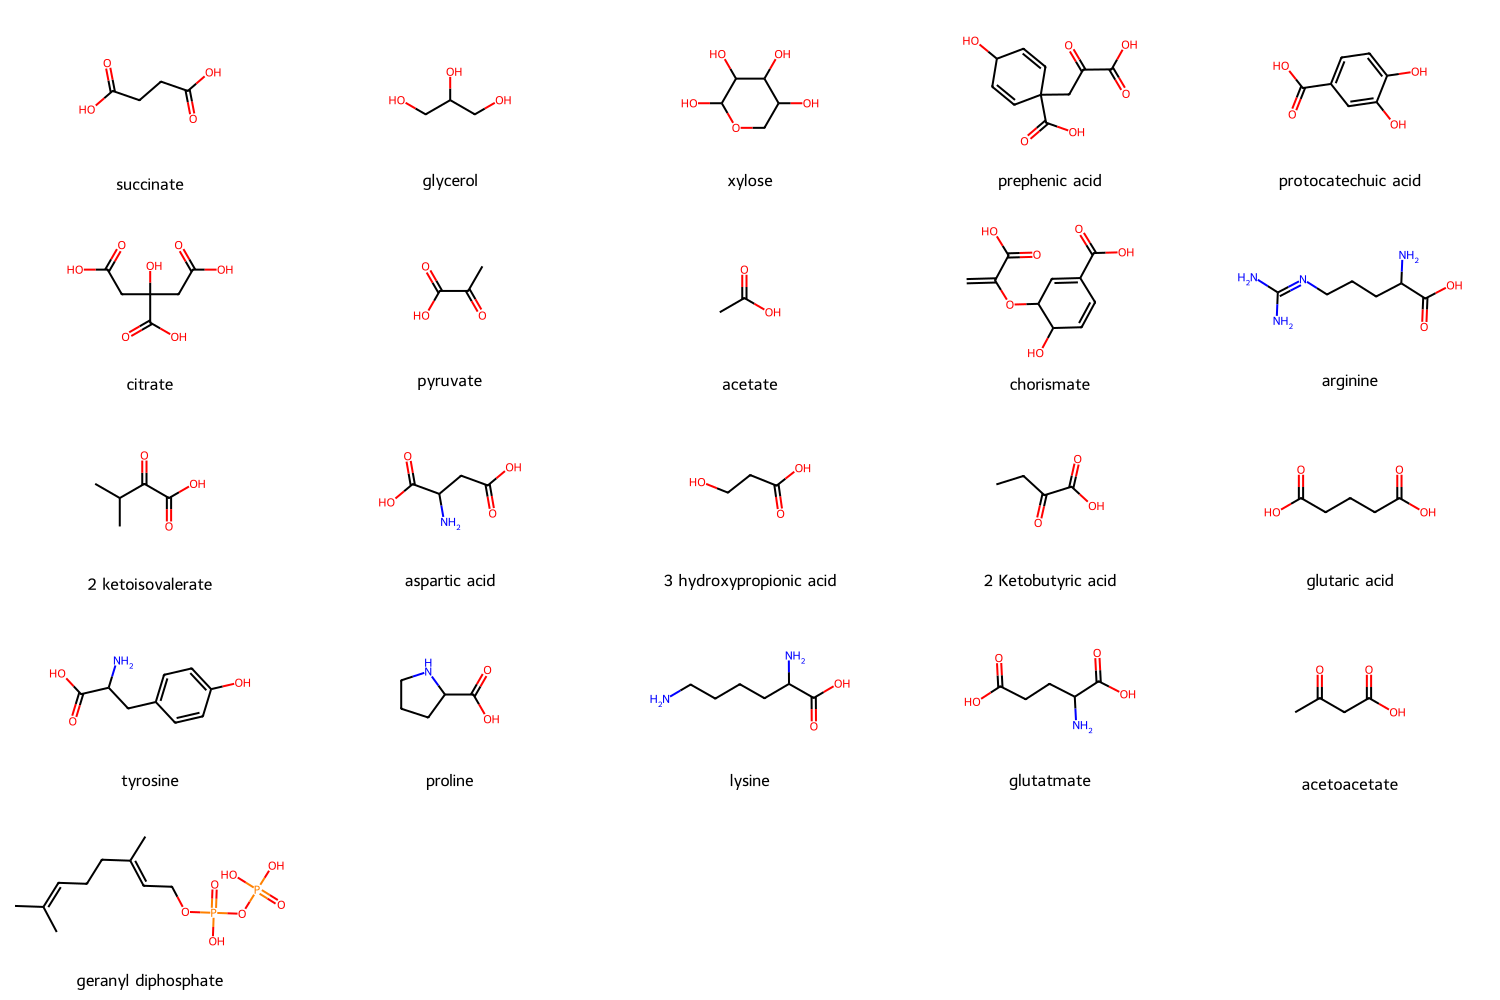

In [2]:
starters_name = "250728_benchmark_starters"

starters = pd.read_csv(Path(cfg.artifacts) / "starters" / f"{starters_name}.csv")
MolsToGridImage(mols=[Chem.MolFromSmiles(s) for s in starters.smiles], molsPerRow=5, subImgSize=(300,200), legends=[name.replace("_"," ") for name in starters.id])

In [3]:
expansion_name = f"2_steps_{starters_name}"
a_plus_b = True
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*compound_metrics.parquet"):
    df = pd.read_parquet(p)
    dfes.append(df)

cpd_df = pd.concat(dfes, ignore_index=True)
cpd_df['expansion'] = cpd_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head()

expansion gen      fan_out  \
                                                                 mean   
0  2_steps_250728_benchmark_starters_rules_imt_ru...   0  4441.238095   
1  2_steps_250728_benchmark_starters_rules_imt_ru...   1   770.442600   
2  2_steps_250728_benchmark_starters_rules_mechin...   0   113.000000   
3  2_steps_250728_benchmark_starters_rules_mechin...   1    36.695733   
4  2_steps_250728_benchmark_starters_rules_mechin...   0   164.761905   

                
           std  
0  8316.820065  
1   608.862718  
2    66.388252  
3    25.166734  
4   158.383050

In [ ]:
known_reactions = {}

for exp_name in cpd_df["expansion"].unique():
    rule_set = exp_name.split("_rules_")[1]
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[exp_name] = rxns

/home/stef/cgr/data/raw/mapped_known_reactions_x_imt_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_01_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_02_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_04_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_13_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_91_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_0_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_2_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_3_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_4_rules.parquet


: 

In [ ]:
ds = 10
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*reaction_metrics.parquet"):
    if "batch" in str(p):
        if int(str(p).split("_")[1]) % ds != 0:
            continue
    
    df = pd.read_parquet(p)
    dfes.append(df)

rxn_df = pd.concat(dfes, ignore_index=True)
rxn_df['expansion'] = rxn_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["expansion"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
print(len(rxn_df))
rxn_df.head()

4250991


In [ ]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean", "std"], "max_rxn_sim": ["mean", "std"]}).head(12)

dxgb_label            \
                                                         mean       std   
expansion                                                                 
2_steps_250728_benchmark_starters_rules_imt_rul...   0.034854  0.183409   
2_steps_250728_benchmark_starters_rules_mechinf...   0.405003  0.490905   
2_steps_250728_benchmark_starters_rules_mechinf...   0.403908  0.490687   
2_steps_250728_benchmark_starters_rules_mechinf...   0.356065  0.478838   
2_steps_250728_benchmark_starters_rules_mechinf...   0.314478  0.464310   
2_steps_250728_benchmark_starters_rules_mechinf...   0.241384  0.427923   
2_steps_250728_benchmark_starters_rules_mechinf...   0.261647  0.439535   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.046726  0.211052   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.360685  0.480205   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.424454  0.494275   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.407085  0.491319   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.385190  0.486676   

                                                   max_rxn_sim            
                                                          mean       std  
expansion                                                                 
2_steps_250728_benchmark_starters_rules_imt_rul...    0.367614  0.240702  
2_steps_250728_benchmark_starters_rules_mechinf...    0.779474  0.151096  
2_steps_250728_benchmark_starters_rules_mechinf...    0.771397  0.156046  
2_steps_250728_benchmark_starters_rules_mechinf...    0.748727  0.185535  
2_steps_250728_benchmark_starters_rules_mechinf...    0.719975  0.194842  
2_steps_250728_benchmark_starters_rules_mechinf...    0.637771  0.222440  
2_steps_250728_benchmark_starters_rules_mechinf...    0.757232  0.167326  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.328146  0.230572  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.824416  0.122164  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.871779  0.091600  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.865223  0.096971  
2_steps_250728_benchmark_starters_rules_rc_plus...    0.847301  0.097057

In [ ]:
ct_df = rxn_df.groupby("expansion").size().reset_index(name="n_rxns")
unscl = ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'].values[0]
ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'] = unscl * ds
ct_df.head()

,expansion,n_rxns
0,2_steps_250728_benchmark_starters_rules_imt_ru...,2165675
1,2_steps_250728_benchmark_starters_rules_mechin...,19790
2,2_steps_250728_benchmark_starters_rules_mechin...,30554
3,2_steps_250728_benchmark_starters_rules_mechin...,66443
4,2_steps_250728_benchmark_starters_rules_mechin...,119859


In [ ]:
list(rxn_df.expansion.unique())

['2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk',
 '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreacta

In [ ]:
exp_names = list(rxn_df.expansion.unique())
perm = [9, 1, 0, 2, 6, 3, 5, 11, 10, 7, 8, 4]  # for plotting in order of increasing RC
exp_names = [exp_names[p] for p in perm]
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.91",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.13",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.04",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.02",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.01",
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': "Pathway-level clustering"
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_91_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_13_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_02_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_01_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("darkorange"),
}

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [ ]:
print(matplotlib.colors.to_rgba("blue"))
print(matplotlib.colors.to_rgba("purple"))
print(matplotlib.colors.to_rgba("black"))
print(matplotlib.colors.to_rgba("green"))

(0.0, 0.0, 1.0, 1.0)
(0.5019607843137255, 0.0, 0.5019607843137255, 1.0)
(0.0, 0.0, 0.0, 1.0)
(0.0, 0.5019607843137255, 0.0, 1.0)


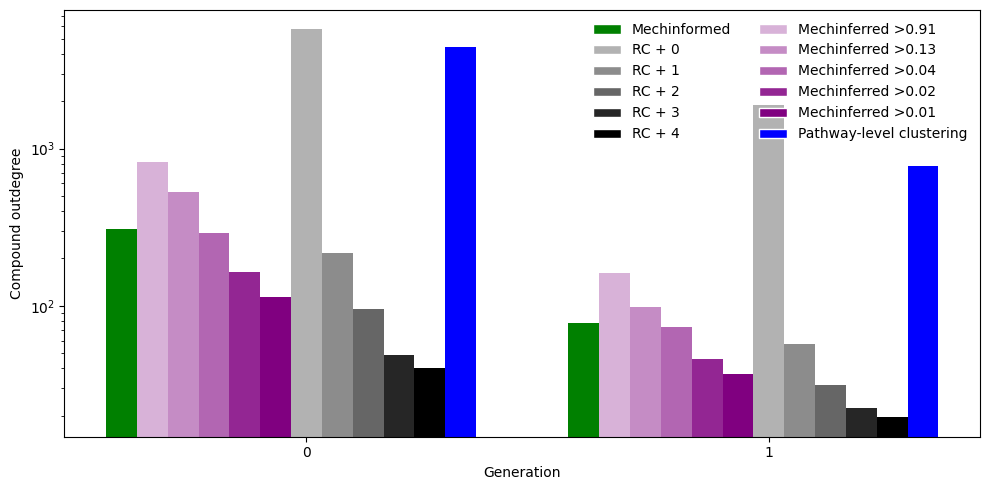

In [ ]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))
ax.set_yscale('log')
ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_fan_out_clustered_bar_graph.svg", format="svg")
plt.show()
        

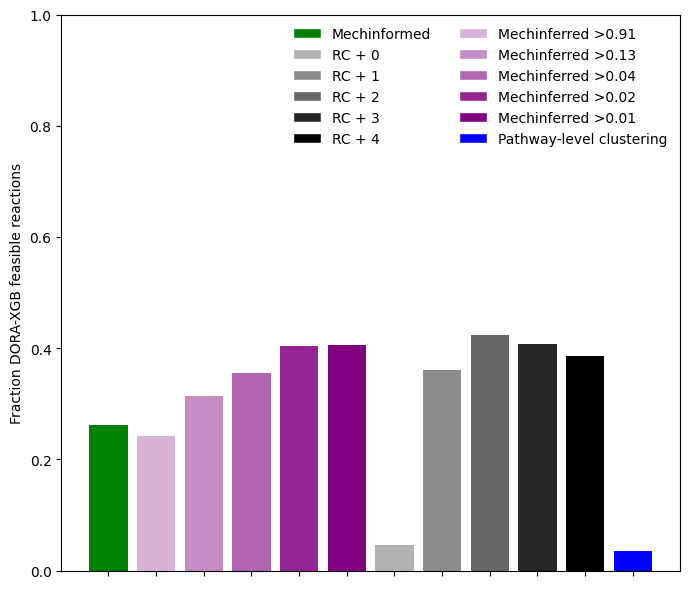

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_feasibility_bar_graph.svg", format="svg")
plt.show()

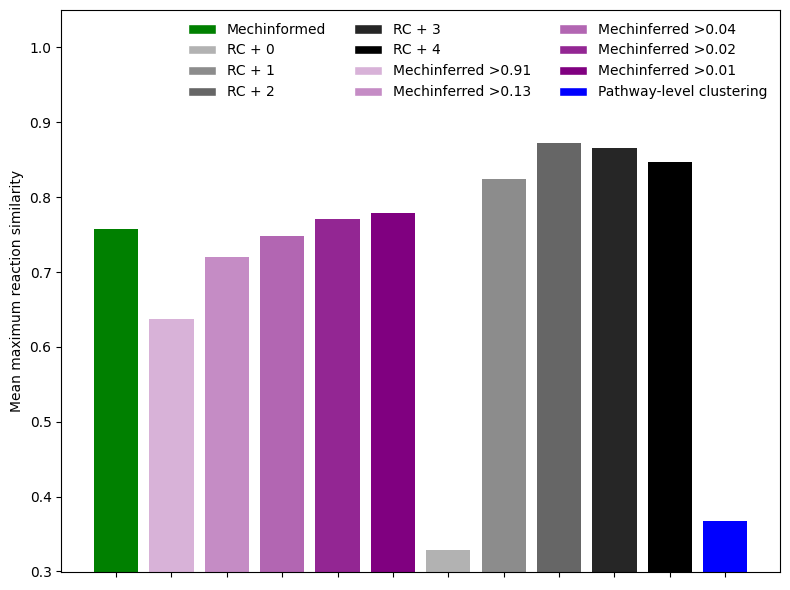

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_bar_graph.svg", format="svg")
plt.show()

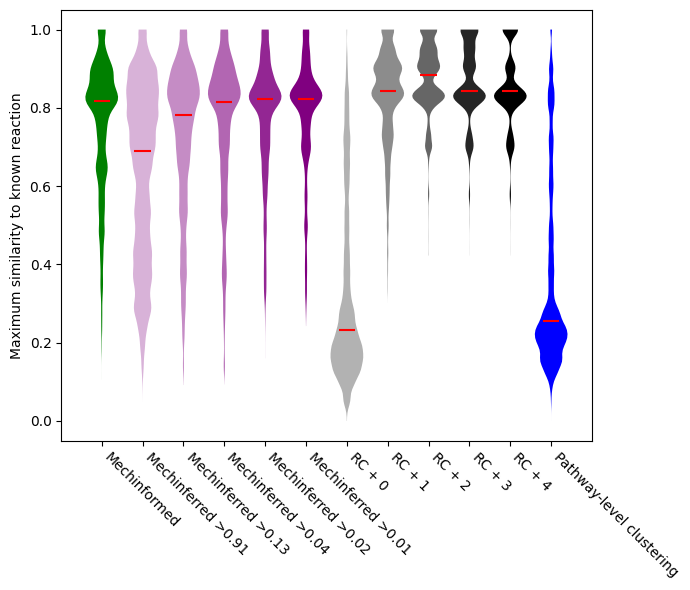

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_violin_plot.svg", format="svg")
plt.show()

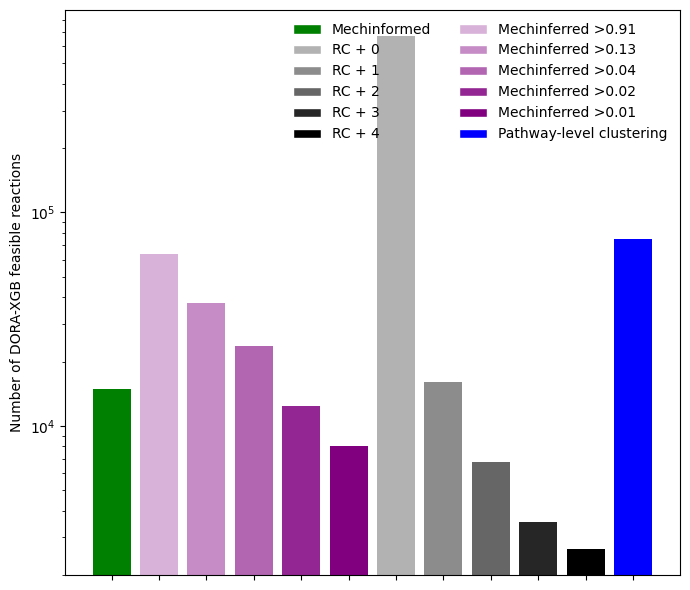

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

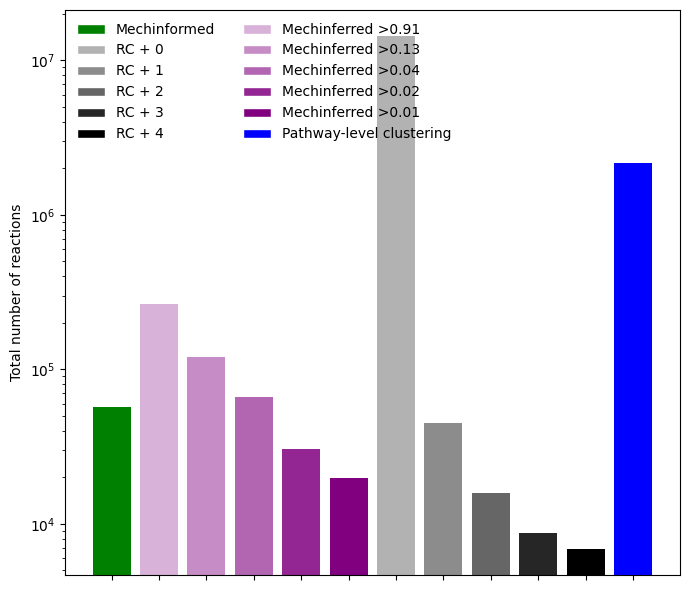

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_bar_graph.svg", format="svg")
plt.show()

In [ ]:
mechinferred_points = []
rcplus_points = []
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    
    if "mechinferred" in exp_name:
        mechinferred_points.append((feas_frac, tot_rxns))

    if "rc_plus" in exp_name:
        rcplus_points.append((feas_frac, tot_rxns))

# Fit lines to the points
mechinferred_points = np.array(mechinferred_points)
rcplus_points = np.array(rcplus_points)

mechinferred_fit = np.polyfit(mechinferred_points[:, 0], np.log10(mechinferred_points[:, 1]), 1)
rcplus_fit = np.polyfit(rcplus_points[:, 0], np.log10(rcplus_points[:, 1]), 1)

# log(y) = mx + b
# y = 10^(mx + b) = 10^b * 10^(mx)
def line_of_best_fit(x, fit):
    m, b = fit
    return 10**b * 10**(m * x)


In [ ]:
mechinferred_fit, rcplus_fit

(array([-6.44491419,  7.03934336]), array([-8.58942041,  7.54720229]))

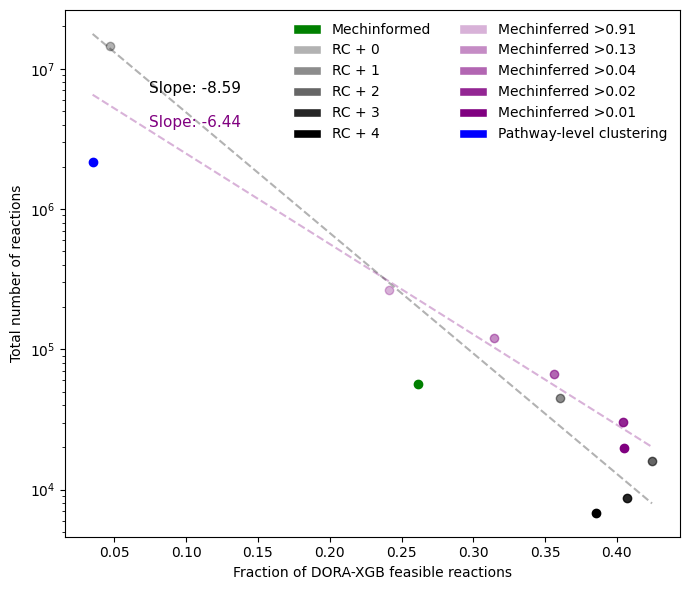

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
xmin = 1.0
xmax = 0.0
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color)

    if feas_frac < xmin:
        xmin = feas_frac
    if feas_frac > xmax:
        xmax = feas_frac

xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, line_of_best_fit(xrange, mechinferred_fit), color=matplotlib.colors.to_rgba("purple", alpha=0.3), linestyle="--", label="Mechinferred fit")
ax.plot(xrange, line_of_best_fit(xrange, rcplus_fit), color=matplotlib.colors.to_rgba("black", alpha=0.3), linestyle="--", label="RC + n fit")

# Add slope labels to the fitted lines
mechinferred_slope = mechinferred_fit[0]
rcplus_slope = rcplus_fit[0]
label_idx = 10

ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], mechinferred_fit),
    f"Slope: {mechinferred_slope:.2f}", color=matplotlib.colors.to_rgba("purple", alpha=1.0),
    va='bottom', ha='left', fontsize=11
)
ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], rcplus_fit),
    f"Slope: {rcplus_slope:.2f}", color=matplotlib.colors.to_rgba("black", alpha=1.0),
    va='top', ha='left', fontsize=11
)
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
ax.set_xlim(0, 0.6)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_feasibility.svg", format="svg")
plt.show()

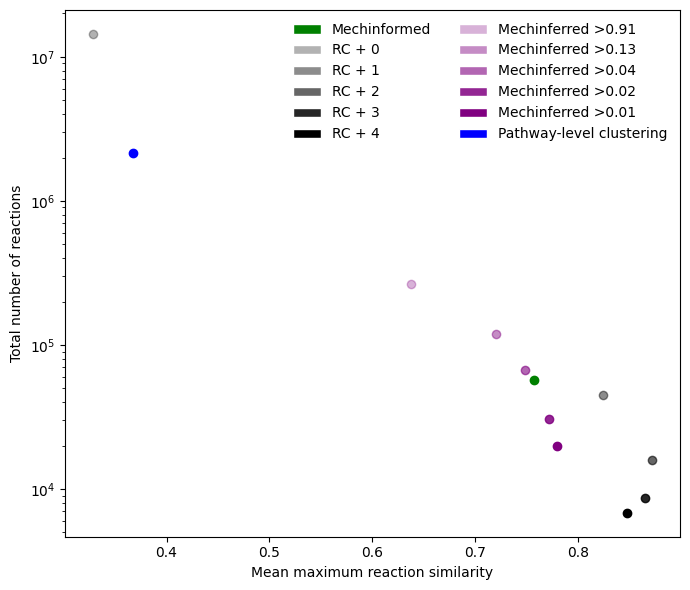

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_mean_max_rxn_sim.svg", format="svg")
plt.show()

In [ ]:
rxn_df.sort_values(by="max_rxn_sim", ascending=False)

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
612241,Rec8761144387bca1d452b6237a0b052eb9d42996b3d9b...,O=P(O)(O)OP(=O)(O)O.CC(=O)SCCNC(=O)CCNC(=O)C(O...,[O:1]=[P:2]([OH:3])([OH:4])[O:5][P:6](=[O:7])(...,0,1.0,O=P(O)(O)OP(=O)(O)O.CC(C)(COP(=O)(O)OP(=O)(O)O...,7584edeffca82f65bf8514e98d744d4e666ba82c,"[12_2, 2458_2, 1695_3, 401_5]",2_steps_250728_benchmark_starters_rules_imt_ru...,False
1514219,R27ca7031c7af6a9774a01cdbacb54fa733e02493e9091...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,1,1.0,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,6863583f0fa59478345ef24880df86830981998c,"[1724_2, 1083_1, 1083_1_0, 1724_2_0]",2_steps_250728_benchmark_starters_rules_imt_ru...,False
1514226,Rb081b589f5c54a3bae8a6a6d2130d4c9edb5c14b613cc...,O=P(O)(O)OP(=O)(O)O.CC(=O)SCCNC(=O)CCNC(=O)C(O...,[O:1]=[P:2]([OH:3])([OH:4])[O:5][P:6](=[O:7])(...,0,1.0,O=P(O)(O)OP(=O)(O)O.CC(C)(COP(=O)(O)OP(=O)(O)O...,7584edeffca82f65bf8514e98d744d4e666ba82c,"[12_2, 2458_2, 1695_3, 401_5]",2_steps_250728_benchmark_starters_rules_imt_ru...,False
845149,R4a8efec167b67589d89a349e11698c16ea4525fff0be4...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,1.0,*NC(COP(=O)(O)OCC(C)(C)C(O)C(=O)NCCC(=O)NCCSC(...,ce2a0cabbf3f4aad39e68b5ab4ba308282682bc5,[2018_2],2_steps_250728_benchmark_starters_rules_imt_ru...,False
613278,R4b5d4950d8f302533f150161eff0555703fa784b4eeb3...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,1,1.0,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,6863583f0fa59478345ef24880df86830981998c,"[1724_2, 1083_1, 1083_1_0, 1724_2_0]",2_steps_250728_benchmark_starters_rules_imt_ru...,False
...,...,...,...,...,...,...,...,...,...,...
2886406,R4c57bae44fe5223fcc39f0f167e608dbd93475609147d...,CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,[658_0],2_steps_250728_benchmark_starters_rules_rc_plu...,False
3740359,R5467979b3876fc7e993ae72d7dd6455166dcee743960c...,CC(=O)SCCNC(=O)CC(CCCC(N)C(=O)O)NC(=O)C(O)C(C)...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,[658_0],2_steps_250728_benchmark_starters_rules_rc_plu...,False
2911781,Rd85900e95cac66ab8e1afa93d2642ab94a03dcdacb3ec...,CC(=O)SC(CNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)O...,[CH3:1][C:2](=[O:3])[S:4][CH:5]([CH2:6][NH:7][...,0,0.0,*C=C(C)C=CC=C(C)C=CC1=C(C)CCCC1(C)C>>*C=C(C)C=...,b0c96b16b4a91412af5da4ade504670e28a19ef6,[658_0],2_steps_250728_benchmark_starters_rules_rc_plu...,False
3929553,R4b381e2b739ba9f64757064d8fc4a8e49e3f398617866...,O=C(O)C(=COP(=O)(O)O)OC1C=C(C(O)O)C=CC1O>>O=C(...,[O:1]=[C:2]([OH:3])[C:4](=[CH:5][O:6][P:7](=[O...,0,0.0,CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP(=O)(O)OP(=O...,70d5c7b2aa20049a57dd252223060e9e7faab14e,[601_0],2_steps_250728_benchmark_starters_rules_rc_plu...,False


Venn diagrams

In [ ]:
rids = {}
for exp_name, short_name in exp_labels.items():
    rids[short_name] = set(rxn_df.loc[rxn_df["expansion"] == exp_name, "id"].values)

rids.pop("RC + 0")

{'R871e075c532810d6f5574c87ca9c6434addc0c73231e5c0d424c3b4aabf36a89',
 'R78a50a1e52327a35ab797263da0395c976d7cc9687a610daeadb92536f3d7d76',
 'R259fbf5be44dbde3a8b9148c50e79d2b508a853cddf59d220eac499abd576c2a',
 'R443b33bd954ed7d58a0c0c83f95b6990f80b56f80abb99709375694ee57c533f',
 'R1951e24cb56afcf26cc6e8e8a52ce6fc347a52c6188bbabcbf8927a6c32e0cc9',
 'R83a0d8d0048329a4b060ed0d56cb0fb6290d0695d8d6982144e60bd7c48b12ff',
 'R3d3b35b48479f6f7ede2593f97bc5a10ed12cb9023c9d4537a8999a7dd87cf23',
 'Rc433350a82703edb28042a8fa501de29be29b9689acbd19390e4b2e6332c11ec',
 'R08baca8462693c4a2e398da2a8ba51025366722450d4a842ed49111d3a6ba59c',
 'Rf54fb9fae30c9735c754fd9d75d348a409ede6422599eaa1fbfa6beef6a9ad46',
 'R2bfe0b559951dbdbfe9907db6a16fa7d647d69250371ef3ebdeb0bbd2fcd0035',
 'R036a07a59036b5442168f8697b7b7d53b1a939d0a79b4c74714a4fc32cdc2f24',
 'R5855945b554f3e05e026ea579de1afd148870f98ddb600694ff009e4b92473bc',
 'R2982afabcf3bb353ab5065676f14b17108a638756e8102414b35c6bf18be982c',
 'Rb9a4754814eb3693e

In [ ]:
def make_venn2(left: set, right: set, left_name: str, right_name: str, left_color: tuple = (0,0,1,1), right_color: tuple = (1,0,0,1), do_save: bool = False):
    Ab = len(left - right)
    aB = len(right - left)
    AB = len(left & right)
    plt.figure()
    v = venn2(subsets = (Ab, aB, AB), set_labels = (left_name, right_name))
    v.get_patch_by_id('10').set_color(left_color)
    v.get_patch_by_id('01').set_color(right_color)

    plt.tight_layout()
    if do_save:
        plt.savefig(Path(cfg.figures) / f"{left_name.replace(' ','_')}_vs_{right_name.replace(' ','_')}_venn2.svg", format="svg")
    plt.show()

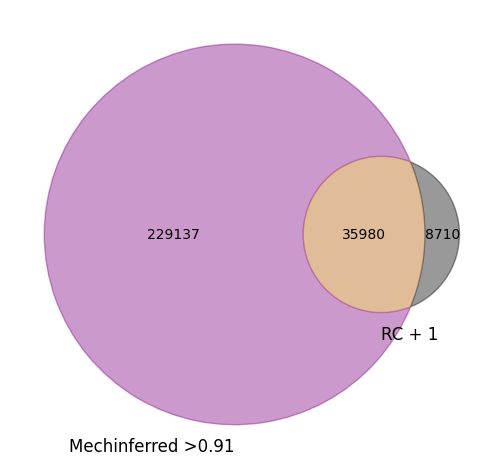

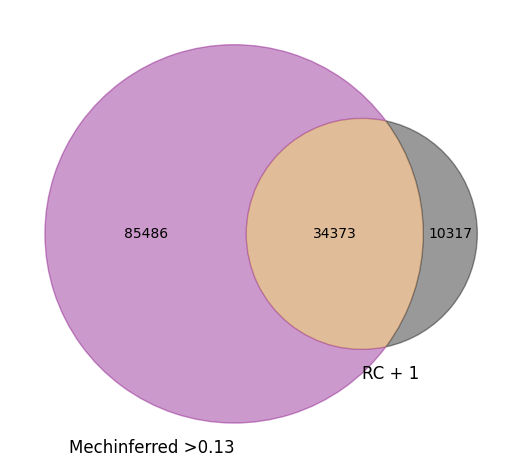

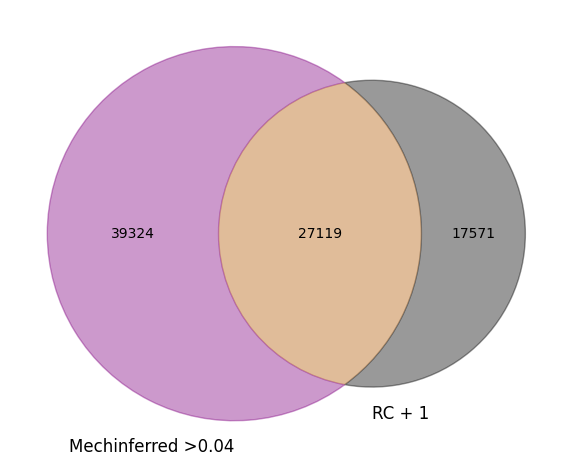

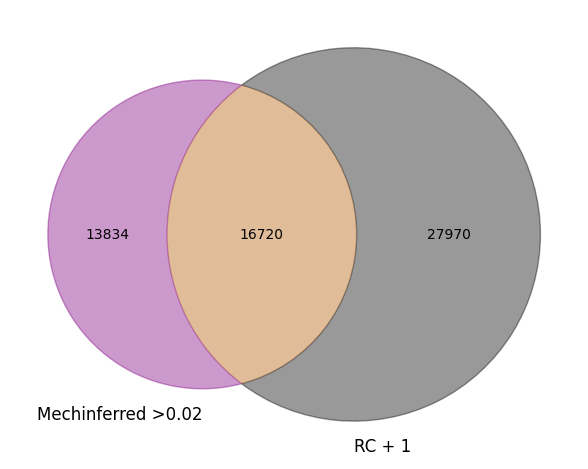

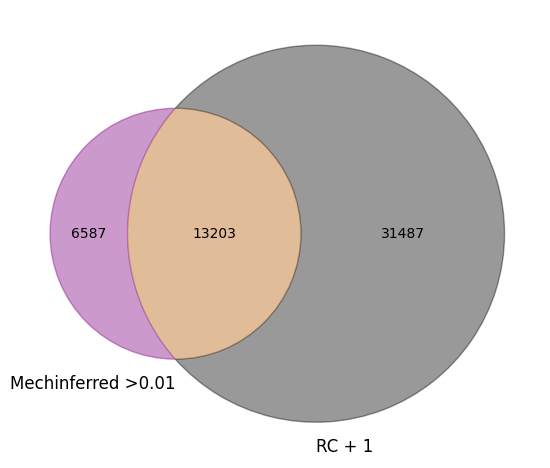

In [ ]:
make_venn2(rids["Mechinferred >0.91"], rids["RC + 1"], "Mechinferred >0.91", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.13"], rids["RC + 1"], "Mechinferred >0.13", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.85), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.04"], rids["RC + 1"], "Mechinferred >0.04", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.6), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.02"], rids["RC + 1"], "Mechinferred >0.02", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.45), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.01"], rids["RC + 1"], "Mechinferred >0.01", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.3), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)

In [ ]:

pk = Pickaxe()
pk.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.


FileNotFoundError: [Errno 2] No such file or directory: '/home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk'

In [ ]:
starters = set()

for cid, cpd in pk.compounds.items():
    if cpd["Type"] == "Starting Compound":
        starters.add(cpd["SMILES"])

In [ ]:
mechinfo_only_df = rxn_df.loc[
    (rxn_df["expansion"] == "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk") & (rxn_df["id"].isin(mechinfo_only))
]

mechinfo_only_df = mechinfo_only_df.sort_values(by=["dxgb_label", "max_rxn_sim"], ascending=False)
print(len(mechinfo_only_df))
mechinfo_only_df_first_gen = mechinfo_only_df.loc[mechinfo_only_df["smarts"].apply(lambda x: any([elt in starters for elt in x.split('>>')[0].split('.')]))].reset_index()
print(len(mechinfo_only_df_first_gen))
mechinfo_only_df_first_gen.head()

7852
2680


,index,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,97,Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35...,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,[CH3:1][C:2](=[O:3])[C:4](=[O:5])[OH:6].[NH2:7...,1,1.000000,CC(=O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)...,2779,[114_0],2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
1,2969,R5a5cc88637c00f9034e0d0cb68e94d1c5e24421ce4dba...,CC(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O...,[CH3:1][CH:2]([OH:3])[OH:4].[NH2:5][c:6]1[n:7]...,1,0.968750,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
2,4708,R8fa2d005dd0d1398abac63b6f657600ed6178a3b174cf...,NC(CC(=O)NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(...,[NH2:1][CH:2]([CH2:3][C:4](=[O:5])[NH:6][P:7](...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
3,6584,R73501d6b2a750d208747db8d3a4afebdd3c89f9b21186...,CSCCC(NP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(COP...,[CH3:1][S:2][CH2:3][CH2:4][CH:5]([NH:6][P:7](=...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False
4,8795,Ra4bc5932324f20abc7eddde141c0d4de72bed4e8cbdc6...,NC(CCCCNP(=O)(O)O)C(=O)O.Nc1ncnc2c1ncn2C1OC(CO...,[NH2:1][CH:2]([CH2:3][CH2:4][CH2:5][CH2:6][NH:...,1,0.939826,O=P(O)(O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)...,900,"[278_0_0, 278_0]",2_steps_ccm_aa_rules_mechinformed_rules_w_core...,False


In [ ]:
def show_rxn_info(idx):
    row = mechinfo_only_df_first_gen.iloc[idx]
    print(row["id"])
    print("Predicted:")
    display(SVG(draw_reaction(row["smarts"])))
    print("-" * 50)
    print("Nearest analogue:")
    display(SVG(draw_reaction(row["nearest_analogue"])))

srt_idx = mechinfo_only_df_first_gen.index
interact(show_rxn_info, idx=widgets.Dropdown(options=srt_idx, value=srt_idx[0]))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.show_rxn_info(idx)>

In [ ]:
rc1exp = Pickaxe()
rc1exp.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk pickled data.
Loaded 5756 compounds
Loaded 9210 reactions
Loaded 3853 operators
Loaded 71 coreactants
Loaded 2 generation
Took 0.4062004089355469


[14:24:25] WARNING: not removing hydrogen atom without neighbors


In [ ]:
rc1exp.reactions['Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9']

KeyError: 'Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9'